<a href="https://colab.research.google.com/github/AdrianoLink-DataScience/E-commerce-Data-Simulator-Analytics/blob/main/E_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛒 E-commerce Data Simulator & Analytics

Este projeto demonstra a construção de um pipeline de dados completo (ETL) utilizando Python, visando simular um cenário real de varejo brasileiro para fins de análise de dados.

![Status](https://img.shields.io/badge/Status-Completed-success) ![Python](https://img.shields.io/badge/Python-3.9%2B-blue)

## 🎯 Objetivos do Projeto
- **Engenharia de Dados:** Criar um gerador de dados sintéticos robusto usando `Faker` com regras de negócio customizadas (pesos demográficos).
- **Armazenamento:** Estruturar um banco de dados relacional (`SQLite`) com tabelas normalizadas.
- **Analytics Avançado:** Utilizar SQL com **Window Functions** (`DENSE_RANK`, `PARTITION BY`) para extrair insights de valor (Clientes VIP por Região).
- **Visualização:** Storytelling de dados com `Seaborn`.

## 🛠 Stack Tecnológico
- **Python Libraries:** Pandas, SQLAlchemy, Faker, Seaborn.
- **Database:** SQLite (In-memory/File).
- **Conceitos:** ETL, Data Modeling, Feature Engineering.

## 📊 Exemplo de Análise (SQL)
O projeto vai além de agregações simples (`GROUP BY`). Abaixo, um exemplo da query utilizada para ranquear os melhores clientes regionalmente:

```sql
DENSE_RANK() OVER (PARTITION BY estado ORDER BY total_investido DESC)

In [1]:
!pip install faker -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.9 MB/s eta 0:00:00


In [2]:
# Definir o conteúdo exato que seu projeto precisa
conteudo ="""pandas
seaborn
matplotlib
sqlalchemy
faker"""

# Criar o arquivo no sistema do Colab
with open('requirements.txt', 'w') as f:
    f.write(conteudo)

print("Arquivo 'requirements.txt' criado com sucesso!")

# Baixar o arquivo para seu computador agora
# from google.colab import files
# files.download('requirements.txt')

Arquivo 'requirements.txt' criado com sucesso!


🔄 Iniciando geração de 1000 clientes e 3000 vendas...
✅ Banco de dados populado com sucesso!

📊 Executando Análise de 'Whales' (Clientes VIP) por Região...


,nome,estado,total_investido,ranking
0,Sr. Breno Pastor,AC,26256.89,1
1,Pietra Marques,AC,19694.09,2
2,Júlia Pinto,AC,16194.21,3
3,Manuela Jesus,AL,24889.56,1
4,Juliana Gomes,AL,16086.33,2
5,Vinícius Garcia,AL,12185.26,3
6,Isadora Pereira,AM,15715.84,1
7,Joana Rezende,AM,14345.10,2
8,Dr. Brayan Vargas,AM,12250.71,3
9,Isabelly Teixeira,AP,19194.64,1



📈 Gerando Gráfico Demográfico Ponderado...


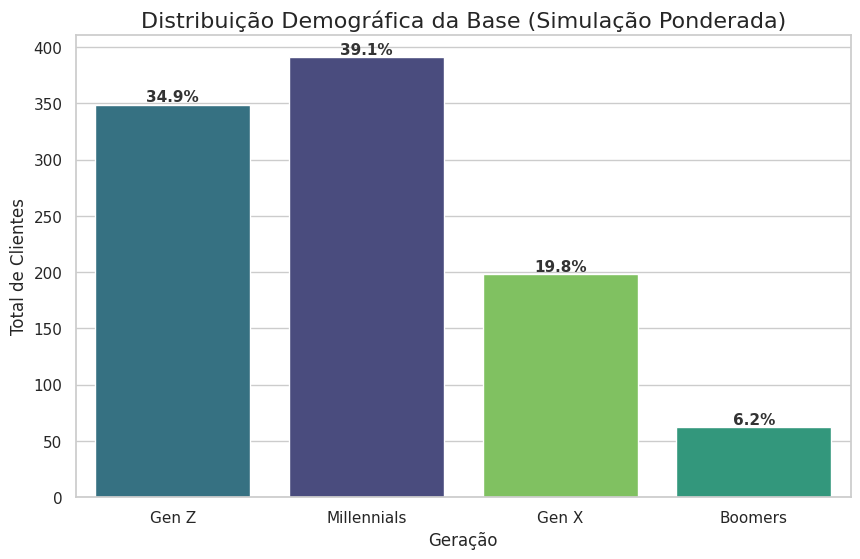

In [3]:
# ==============================================================================
# 1. SETUP E CONSTANTES GLOBAIS
# ==============================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from datetime import date, timedelta
from faker import Faker
from sqlalchemy import create_engine

# Configuração Visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Configurações do Banco de Dados
DB_NAME = 'ecommerce_profissional.db'
ENGINE = create_engine(f'sqlite:///{DB_NAME}')
FAKE = Faker('pt_BR')

# Regras de Negócio (Constantes)
# Simulação: Loja focada em público jovem/adulto (Tecnologia/Moda)
PERFIL_DEMOGRAFICO = [
    {"faixa": (18, 24), "peso": 35, "label": "Gen Z"},
    {"faixa": (25, 39), "peso": 40, "label": "Millennials"},
    {"faixa": (40, 59), "peso": 20, "label": "Gen X"},
    {"faixa": (60, 90), "peso": 5,  "label": "Boomers"}
]

CATEGORIAS = {
    'Eletrônicos': (500, 5000),  # (Preço Mín, Preço Máx)
    'Moda': (50, 400),
    'Casa & Decor': (100, 1500),
    'Livros & Games': (30, 300)
}

# ==============================================================================
# 2. FUNÇÕES AUXILIARES (ENGINEERING)
# ==============================================================================

def gerar_perfil_ponderado():
    """Gera dados demográficos baseados nos pesos definidos na constante."""
    # Extrair listas para o random.choices
    faixas = [p["faixa"] for p in PERFIL_DEMOGRAFICO]
    pesos = [p["peso"] for p in PERFIL_DEMOGRAFICO]
    labels = [p["label"] for p in PERFIL_DEMOGRAFICO]

    # Sortear o perfil
    idx = random.choices(range(len(faixas)), weights=pesos, k=1)[0]

    # Gerar idade exata dentro da faixa sorteada
    idade_min, idade_max = faixas[idx]
    idade = random.randint(idade_min, idade_max)

    # Gerar data de nascimento consistente com a idade
    d_nasc = FAKE.date_of_birth(minimum_age=idade, maximum_age=idade)

    return idade, d_nasc, labels[idx]

def popular_banco_de_dados(qtd_clientes=1000, qtd_vendas=3000):
    """Executa o pipeline de geração de dados e salva no SQLite."""
    print(f"🔄 Iniciando geração de {qtd_clientes} clientes e {qtd_vendas} vendas...")

    # --- 1. Gerar Clientes ---
    clientes = []
    for _ in range(qtd_clientes):
        idade, d_nasc, geracao = gerar_perfil_ponderado()
        clientes.append({
            'id_cliente': FAKE.uuid4(),
            'nome': FAKE.name(),
            'estado': FAKE.state_abbr(),
            'idade': idade,
            'data_nascimento': d_nasc,
            'geracao': geracao,
            'email': FAKE.email()
        })
    df_clientes = pd.DataFrame(clientes)
    df_clientes.to_sql('clientes', ENGINE, if_exists='replace', index=False)

    # --- 2. Gerar Produtos ---
    produtos = []
    id_prod = 1
    for cat, (p_min, p_max) in CATEGORIAS.items():
        for _ in range(10): # 10 produtos por categoria
            produtos.append({
                'id_produto': id_prod,
                'nome_produto': f"{cat} - {FAKE.word().capitalize()} {id_prod}",
                'categoria': cat,
                'preco': round(random.uniform(p_min, p_max), 2)
            })
            id_prod += 1
    df_produtos = pd.DataFrame(produtos)
    df_produtos.to_sql('produtos', ENGINE, if_exists='replace', index=False)

    # --- 3. Gerar Vendas ---
    vendas = []
    ids_cli = df_clientes['id_cliente'].tolist()
    ids_prod = df_produtos['id_produto'].tolist()

    for _ in range(qtd_vendas):
        vendas.append({
            'id_venda': FAKE.uuid4(),
            'id_cliente': random.choice(ids_cli),
            'id_produto': random.choice(ids_prod),
            'data_venda': FAKE.date_between(start_date='-1y', end_date='today'),
            'quantidade': random.randint(1, 3)
        })
    df_vendas = pd.DataFrame(vendas)
    df_vendas.to_sql('vendas', ENGINE, if_exists='replace', index=False)

    print("✅ Banco de dados populado com sucesso!")

# ==============================================================================
# 3. EXECUÇÃO DO ETL
# ==============================================================================
# Executa a geração (pode demorar alguns segundos)
popular_banco_de_dados()

# ==============================================================================
# 4. ANÁLISE SQL AVANÇADA (WINDOW FUNCTIONS)
# ==============================================================================
print("\n📊 Executando Análise de 'Whales' (Clientes VIP) por Região...")

# Query Sênior: Ranking de clientes por gasto DENTRO de cada estado
query_vip = """
WITH GastoPorCliente AS (
    SELECT
        c.nome,
        c.estado,
        SUM(v.quantidade * p.preco) as total_investido
    FROM vendas v
    JOIN clientes c ON v.id_cliente = c.id_cliente
    JOIN produtos p ON v.id_produto = p.id_produto
    GROUP BY c.id_cliente
),
RankingRegional AS (
    SELECT
        nome,
        estado,
        total_investido,
        DENSE_RANK() OVER (
            PARTITION BY estado
            ORDER BY total_investido DESC
        ) as ranking
    FROM GastoPorCliente
)
SELECT * FROM RankingRegional
WHERE ranking <= 3 -- Apenas Top 3 de cada estado
ORDER BY estado, ranking;
"""

df_vip = pd.read_sql_query(query_vip, ENGINE)
display(df_vip.head(10)) # Mostrando amostra dos primeiros estados

# ==============================================================================
# 5. VISUALIZAÇÃO DE DADOS (SEABORN)
# ==============================================================================
print("\n📈 Gerando Gráfico Demográfico Ponderado...")

# Recuperar dados atualizados para o gráfico
df_analise = pd.read_sql_query("SELECT geracao FROM clientes", ENGINE)

plt.figure(figsize=(10, 6))
ordem_geracoes = ['Gen Z', 'Millennials', 'Gen X', 'Boomers']

# Countplot com correção do aviso de depreciação (hue + legend=False)
ax = sns.countplot(
    data=df_analise,
    x='geracao',
    order=ordem_geracoes,
    hue='geracao',
    legend=False,
    palette='viridis'
)

# Adicionar labels de porcentagem
total = len(df_analise)
for p in ax.patches:
    height = p.get_height()
    percent = f'{100 * height / total:.1f}%'
    ax.annotate(percent, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=11, fontweight='bold', color='#333')

plt.title('Distribuição Demográfica da Base (Simulação Ponderada)', fontsize=16)
plt.xlabel('Geração', fontsize=12)
plt.ylabel('Total de Clientes', fontsize=12)
plt.show()